In [15]:
#load packages, load data, display columns

import pandas as pd
from treys import Card, Evaluator
import matplotlib.pyplot as plt

# Load Parquet file
df = pd.read_parquet('pokerdata.parquet')

df.columns

Index(['file', 'room', 'blinds', 'game', 'hand', 'won', 'firstcard',
       'secondcard', 'flop1', 'flop2',
       ...
       'player6_preflop_check', 'player6_flop_fold', 'player6_flop_bet',
       'player6_flop_check', 'player6_turn_fold', 'player6_turn_bet',
       'player6_turn_check', 'player6_river_fold', 'player6_river_bet',
       'player6_river_check'],
      dtype='object', length=112)

In [16]:
# select hands where player0 made a preflop bet
played_hands = df[df['player0_preflop_bet'] > 0]

# Compute figures about the hands played
won_count = played_hands[played_hands['won'] == 1].shape[0]
loss_count = played_hands[played_hands['won'] == 0].shape[0]
print(f"Number of wins: {won_count}")
print(f"Number of losses: {loss_count}")
print(f"Total hands: {won_count + loss_count}")
print(f"Win rate: {won_count / (won_count + loss_count) * 100:.2f}%")

Number of wins: 6502
Number of losses: 5568
Total hands: 12070
Win rate: 53.87%


In [17]:
#consolidate bets
#hero
df['player0_flop_bet'] = df['player0_preflop_bet'] + df['player0_flop_bet']
df['player0_turn_bet'] = df['player0_flop_bet'] + df['player0_turn_bet']
df['player0_river_bet'] = df['player0_turn_bet'] + df['player0_river_bet']
df['player0_bet'] =  df['player0_river_bet']

#villain
df['opponent_preflop_bets'] = df['player1_preflop_bet'] + df['player2_preflop_bet'] + df['player3_preflop_bet'] + df['player4_preflop_bet'] + df['player5_preflop_bet'] + df['player6_preflop_bet']
df['opponent_flop_bets'] = df['opponent_preflop_bets'] + df['player0_flop_bet']  + df['player1_flop_bet'] + df['player2_flop_bet'] + df['player3_flop_bet'] + df['player4_flop_bet'] + df['player5_flop_bet'] + df['player6_flop_bet']
df['opponent_turn_bets'] = df['opponent_flop_bets'] + df['player0_turn_bet']  + df['player1_turn_bet'] + df['player2_turn_bet'] + df['player3_turn_bet'] + df['player4_turn_bet'] + df['player5_turn_bet'] + df['player6_turn_bet']
df['opponent_river_bets']  = df['opponent_turn_bets'] + df['player0_river_bet']  + df['player1_river_bet'] + df['player2_river_bet'] + df['player3_river_bet'] + df['player4_river_bet'] + df['player5_river_bet'] + df['player6_river_bet']
df['opponent_bet'] = df['opponent_river_bets'] 

In [18]:
#create the analysis dataframe
analysis_df = df[['room','blinds','game','hand','won','firstcard','secondcard','flop1','flop2','flop3','turn','river','player0_preflop_fold','player0_flop_fold' ,'player0_turn_fold', 'player0_river_fold','player0_preflop_bet','player0_flop_bet','player0_turn_bet','player0_river_bet' ,'player0_bet','opponent_preflop_bets','opponent_flop_bets','opponent_turn_bets','opponent_river_bets' ,'opponent_bet']][df['player0_preflop_bet'] > 0]
analysis_df['player0_preflop_bet'] = analysis_df['player0_preflop_bet'] / analysis_df['blinds']
analysis_df['player0_flop_bet'] = analysis_df['player0_flop_bet'] / analysis_df['blinds']
analysis_df['player0_turn_bet'] = analysis_df['player0_turn_bet'] / analysis_df['blinds']
analysis_df['player0_river_bet'] = analysis_df['player0_river_bet'] / analysis_df['blinds']
analysis_df['player0_bet'] = analysis_df['player0_bet'] / analysis_df['blinds']
analysis_df['opponent_preflop_bets'] = analysis_df['opponent_preflop_bets'] / analysis_df['blinds']
analysis_df['opponent_flop_bets'] = analysis_df['opponent_flop_bets'] / analysis_df['blinds']
analysis_df['opponent_turn_bets'] = analysis_df['opponent_turn_bets'] / analysis_df['blinds']
analysis_df['opponent_river_bets'] = analysis_df['opponent_river_bets'] / analysis_df['blinds']
analysis_df['opponent_bet'] = analysis_df['opponent_bet'] / analysis_df['blinds']

In [19]:
# Starthand strategy classification
# Preflop strategy classification with Chatgpt after a discussion about GTO
strategy_4bet = {'AA', 'KK', 'AKs', 'AKo'}
strategy_3bet = {'AQs', 'QQ', 'JJ', 'TT'}
strategy_call = {
    'AJs', 'ATs', 'A9s', 'A8s', 'A7s', 'A6s', 'A5s', 'A4s', 'A3s', 'A2s',
    'AQo', 'AJo', 'ATo', 'KQo', 'KJo', 'QJo',
    'KQs', 'KJs', 'KTs', 'K9s',
    'QJs', 'QTs', 'Q9s',
    'JTs', 'J9s', 'T9s', '98s', '87s', '76s', '65s', '54s',
    '99', '88', '77', '66', '55', '44', '33', '22'
}

In [20]:
#methods for hand classification
def get_hand_shorthand(card1, card2):
    rank_order = '23456789TJQKA'

    r1, s1 = card1[0], card1[1]
    r2, s2 = card2[0], card2[1]

    # Pocket pair
    if r1 == r2:
        return r1 + r2

    # Sort ranks descending for consistency
    if rank_order.index(r1) > rank_order.index(r2):
        high, low = r1, r2
    else:
        high, low = r2, r1

    suited = 's' if s1 == s2 else 'o'
    return high + low + suited

def classify_starthand(row):
    shorthand = get_hand_shorthand(row['firstcard'], row['secondcard'])
    if shorthand in strategy_4bet:
        return '4-Bet'
    elif shorthand in strategy_3bet:
        return '3-Bet'
    elif shorthand in strategy_call:
        return 'Call'
    else:
        return 'Fold'

In [21]:
#classify the starthand
analysis_df['starthandstrategy'] = analysis_df.apply(classify_starthand, axis=1)

In [22]:
#methods for hand evaluation
evaluator = Evaluator()

def evaluate_postflop(row):
    # Extract cards
    cards = [row['firstcard'], row['secondcard'], row['flop1'], row['flop2'], row['flop3']]

    # Check for nulls
    if any(pd.isnull(card) for card in cards):
        return None  # or "Incomplete Flop" if you want a string

    try:
        treys_hand = [Card.new(card) for card in cards]
        score = evaluator.evaluate([], treys_hand)
        hand_class = evaluator.get_rank_class(score)
        return evaluator.class_to_string(hand_class)
    except Exception as e:
        pass

def evaluate_turn(row):
    # Extract 6 cards
    cards = [row['firstcard'], row['secondcard'],
             row['flop1'], row['flop2'], row['flop3'], row['turn']]

    # Check for any null/missing cards
    if any(pd.isnull(card) for card in cards):
        return 'Incomplete Hand'

    try:
        # Convert to treys card format
        treys_hand = [Card.new(card) for card in cards]

        # Evaluate best hand using all 6 cards
        score = evaluator.evaluate([], treys_hand)
        hand_class = evaluator.get_rank_class(score)
        return evaluator.class_to_string(hand_class)
    except Exception as e:
        pass

def evaluate_river(row):
    # Extract all 7 cards
    cards = [row['firstcard'], row['secondcard'],
             row['flop1'], row['flop2'], row['flop3'],
             row['turn'], row['river']
     ]

    # Check for any missing cards
    if any(pd.isnull(card) for card in cards):
        return 'Incomplete Hand'

    try:
        treys_hand = [Card.new(card) for card in cards]
        score = evaluator.evaluate([], treys_hand)
        hand_class = evaluator.get_rank_class(score)
        return evaluator.class_to_string(hand_class)
    except Exception as e:
        pass

In [23]:
#evaluate the hands
analysis_df['flop_hand'] = analysis_df.apply(evaluate_postflop, axis=1)
analysis_df['turn_hand'] = analysis_df.apply(evaluate_turn, axis=1)
analysis_df['river_hand'] = analysis_df.apply(evaluate_river, axis=1)
analysis_df['river_hand'].unique()

array([None, 'Two Pair', 'High Card', 'Pair', 'Three of a Kind',
       'Full House', 'Flush', 'Straight', 'Four of a Kind'], dtype=object)

In [24]:
#print figures for combination occurances
#flop figures
print("Flop figures")
print(
analysis_df[analysis_df['flop_hand'] == 'Royal Flush'].shape[0],
analysis_df[analysis_df['flop_hand'] == 'Straight Flush'].shape[0],
analysis_df[analysis_df['flop_hand'] == 'Four of a Kind'].shape[0],
analysis_df[analysis_df['flop_hand'] == 'Full House'].shape[0],
analysis_df[analysis_df['flop_hand'] == 'Flush'].shape[0],
analysis_df[analysis_df['flop_hand'] == 'Straight'].shape[0],
analysis_df[analysis_df['flop_hand'] == 'Three of a Kind'].shape[0],
analysis_df[analysis_df['flop_hand'] == 'Two Pair'].shape[0],
analysis_df[analysis_df['flop_hand'] == 'Pair'].shape[0],
analysis_df[analysis_df['flop_hand'] == 'High Card'].shape[0],
analysis_df[analysis_df['flop_hand'].isnull()].shape[0])

print("Flop figures %")
print(
round(analysis_df[analysis_df['flop_hand'] == 'Royal Flush'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['flop_hand'] == 'Straight Flush'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['flop_hand'] == 'Four of a Kind'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['flop_hand'] == 'Full House'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['flop_hand'] == 'Flush'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['flop_hand'] == 'Straight'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['flop_hand'] == 'Three of a Kind'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['flop_hand'] == 'Two Pair'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['flop_hand'] == 'Pair'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['flop_hand'] == 'High Card'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['flop_hand'].isnull()].shape[0] / analysis_df.shape[0] * 100,2)
)

#turn figures

print("Turn figures")
print(
analysis_df[analysis_df['turn_hand'] == 'Royal Flush'].shape[0],
analysis_df[analysis_df['turn_hand'] == 'Straight Flush'].shape[0],
analysis_df[analysis_df['turn_hand'] == 'Four of a Kind'].shape[0],
analysis_df[analysis_df['turn_hand'] == 'Full House'].shape[0],
analysis_df[analysis_df['turn_hand'] == 'Flush'].shape[0],
analysis_df[analysis_df['turn_hand'] == 'Straight'].shape[0],
analysis_df[analysis_df['turn_hand'] == 'Three of a Kind'].shape[0],
analysis_df[analysis_df['turn_hand'] == 'Two Pair'].shape[0],
analysis_df[analysis_df['turn_hand'] == 'Pair'].shape[0],
analysis_df[analysis_df['turn_hand'] == 'High Card'].shape[0],
analysis_df[analysis_df['turn_hand'].isnull()].shape[0])

print("Turn figures %")
print(
round(analysis_df[analysis_df['turn_hand'] == 'Royal Flush'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['turn_hand'] == 'Straight Flush'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['turn_hand'] == 'Four of a Kind'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['turn_hand'] == 'Full House'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['turn_hand'] == 'Flush'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['turn_hand'] == 'Straight'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['turn_hand'] == 'Three of a Kind'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['turn_hand'] == 'Two Pair'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['turn_hand'] == 'Pair'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['turn_hand'] == 'High Card'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['turn_hand'].isnull()].shape[0] / analysis_df.shape[0] * 100,2)
)


#river figures
print("River figures")
print(
analysis_df[analysis_df['river_hand'] == 'Royal Flush'].shape[0],
analysis_df[analysis_df['river_hand'] == 'Straight Flush'].shape[0],
analysis_df[analysis_df['river_hand'] == 'Four of a Kind'].shape[0],
analysis_df[analysis_df['river_hand'] == 'Full House'].shape[0],
analysis_df[analysis_df['river_hand'] == 'Flush'].shape[0],
analysis_df[analysis_df['river_hand'] == 'Straight'].shape[0],
analysis_df[analysis_df['river_hand'] == 'Three of a Kind'].shape[0],
analysis_df[analysis_df['river_hand'] == 'Two Pair'].shape[0],
analysis_df[analysis_df['river_hand'] == 'Pair'].shape[0],
analysis_df[analysis_df['river_hand'] == 'High Card'].shape[0],
analysis_df[analysis_df['river_hand'].isnull()].shape[0])

print("River figures %")
print(
round(analysis_df[analysis_df['river_hand'] == 'Royal Flush'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['river_hand'] == 'Straight Flush'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['river_hand'] == 'Four of a Kind'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['river_hand'] == 'Full House'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['river_hand'] == 'Flush'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['river_hand'] == 'Straight'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['river_hand'] == 'Three of a Kind'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['river_hand'] == 'Two Pair'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['river_hand'] == 'Pair'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['river_hand'] == 'High Card'].shape[0] / analysis_df.shape[0] * 100,2),
round(analysis_df[analysis_df['river_hand'].isnull()].shape[0] / analysis_df.shape[0] * 100,2)
)



Flop figures
0 0 3 14 19 39 260 484 3709 3694 3848
Flop figures %
0.0 0.0 0.02 0.12 0.16 0.32 2.15 4.01 30.73 30.6 31.88
Turn figures
0 0 6 59 79 118 317 797 2752 1653 6289
Turn figures %
0.0 0.0 0.05 0.49 0.65 0.98 2.63 6.6 22.8 13.7 52.1
River figures
0 0 12 150 177 220 258 1057 1805 604 7787
River figures %
0.0 0.0 0.1 1.24 1.47 1.82 2.14 8.76 14.95 5.0 64.52


In [25]:
# Define the strategy DataFrame
strategy_df = analysis_df[['room','game','hand','won','player0_preflop_fold','player0_flop_fold' ,'player0_turn_fold', 'player0_river_fold' ,'player0_bet','player0_preflop_bet','player0_flop_bet','player0_turn_bet','player0_river_bet','opponent_preflop_bets','opponent_flop_bets','opponent_turn_bets','opponent_river_bets' ,'opponent_bet','starthandstrategy','flop_hand','turn_hand','river_hand']]
strategy_df

,room,game,hand,won,player0_preflop_fold,player0_flop_fold,player0_turn_fold,player0_river_fold,player0_bet,player0_preflop_bet,...,player0_river_bet,opponent_preflop_bets,opponent_flop_bets,opponent_turn_bets,opponent_river_bets,opponent_bet,starthandstrategy,flop_hand,turn_hand,river_hand
0,Halley,1,1,1,0,0,0,0,16.5,2.0,...,16.5,5.0,16.0,44.0,60.5,60.5,Fold,Pair,Pair,None
1,Halley,1,2,0,0,1,0,0,0.5,0.5,...,0.5,1.5,3.0,3.5,4.0,4.0,Call,Pair,None,None
3,Halley,1,4,0,0,0,0,1,6.0,3.0,...,6.0,5.0,17.0,23.0,37.0,37.0,Call,Pair,Two Pair,Two Pair
7,Halley,1,8,0,1,0,0,0,2.0,2.0,...,2.0,9.5,11.5,13.5,15.5,15.5,Fold,None,None,None
14,Halley,1,15,0,0,0,1,0,3.0,2.0,...,3.0,7.5,9.5,20.0,23.0,23.0,Call,Two Pair,Two Pair,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48376,Aludra,605,36,0,0,0,0,1,11.9,3.0,...,11.9,5.0,13.4,39.5,86.1,86.1,Call,Pair,Pair,Pair
48378,Aludra,605,38,0,0,0,0,0,60.8,6.5,...,60.8,13.0,33.0,44.0,261.2,261.2,Call,Three of a Kind,Three of a Kind,Three of a Kind
48379,Donati,606,1,1,0,0,0,0,59.0,11.0,...,59.0,22.0,60.0,176.0,235.0,235.0,Call,Pair,Pair,None
48380,Donati,606,2,0,0,1,0,0,3.0,3.0,...,3.0,5.0,11.0,14.0,17.0,17.0,Fold,High Card,None,None


In [26]:
strategy_df.to_csv('thesis_data.csv', index=False)

In [45]:
#Chart data
chart_unfiltered = strategy_df[['won','starthandstrategy','flop_hand','turn_hand','river_hand','player0_bet','opponent_bet']]

flop = strategy_df[(~strategy_df['flop_hand'].isin([None])) ][['won','starthandstrategy','flop_hand','turn_hand','river_hand','player0_bet','opponent_bet']]

turn = strategy_df[(~strategy_df['turn_hand'].isin([None]))][['won','starthandstrategy','flop_hand','turn_hand','river_hand','player0_bet','opponent_bet']]

river = strategy_df[(~strategy_df['river_hand'].isin([None]))][['won','starthandstrategy','flop_hand','turn_hand','river_hand','player0_bet','opponent_bet']]

In [36]:
chart_unfiltered.groupby('starthandstrategy')['player0_bet'].describe()

,count,mean,std,min,25%,50%,75%,max
starthandstrategy,,,,,,,,
3-Bet,696.0,20.806193,29.084806,0.5,3.0,9.2,21.325,239.0
4-Bet,933.0,34.083001,39.456873,0.5,3.0,11.0,67.720,177.7
Call,6667.0,9.572173,16.403214,0.5,2.4,3.0,8.700,214.8
Fold,3774.0,7.864542,13.951847,0.5,2.2,3.0,7.200,147.2


In [49]:
chart_unfiltered['opponent_bet'].describe()

count    12070.000000
mean        54.402737
std         86.639162
min          2.000000
25%         12.000000
50%         23.500000
75%         48.900000
max        957.000000
Name: opponent_bet, dtype: float64

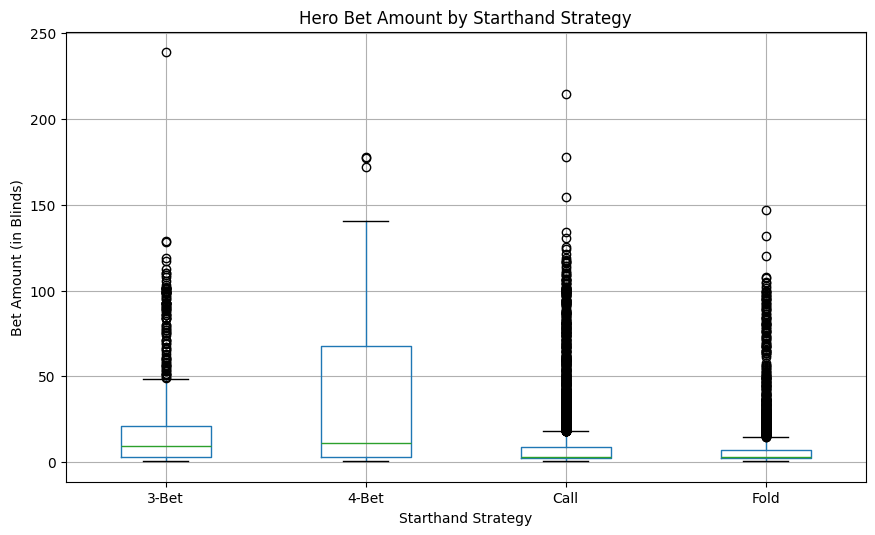

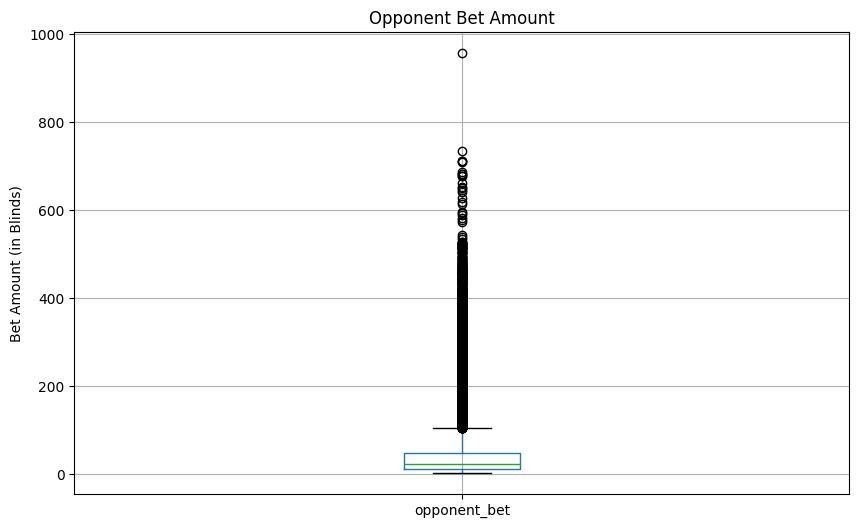

In [48]:
#Chart data hero
chart_unfiltered.boxplot(column='player0_bet', by='starthandstrategy', figsize=(10, 6), grid=True)
plt.title('Hero Bet Amount by Starthand Strategy')
plt.suptitle('')
plt.xlabel('Starthand Strategy')
plt.ylabel('Bet Amount (in Blinds)')
plt.savefig("player0_starthand.png")
plt.show()



#Chart data opponent
chart_unfiltered.boxplot(column='opponent_bet', figsize=(10, 6), grid=True)
plt.title('Opponent Bet Amount')
plt.suptitle('')
plt.xlabel('')
plt.ylabel('Bet Amount (in Blinds)')
plt.savefig("opponent_starthand.png", dpi=300, bbox_inches='tight')
plt.show()



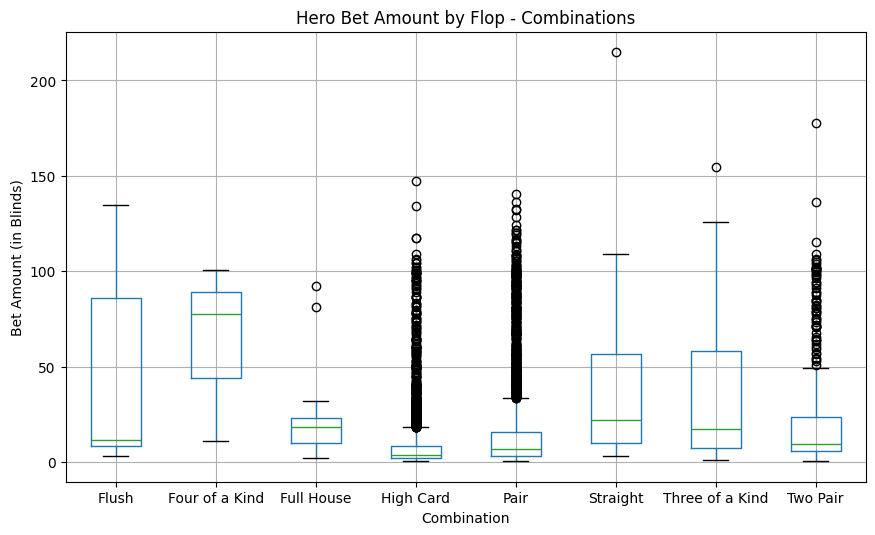

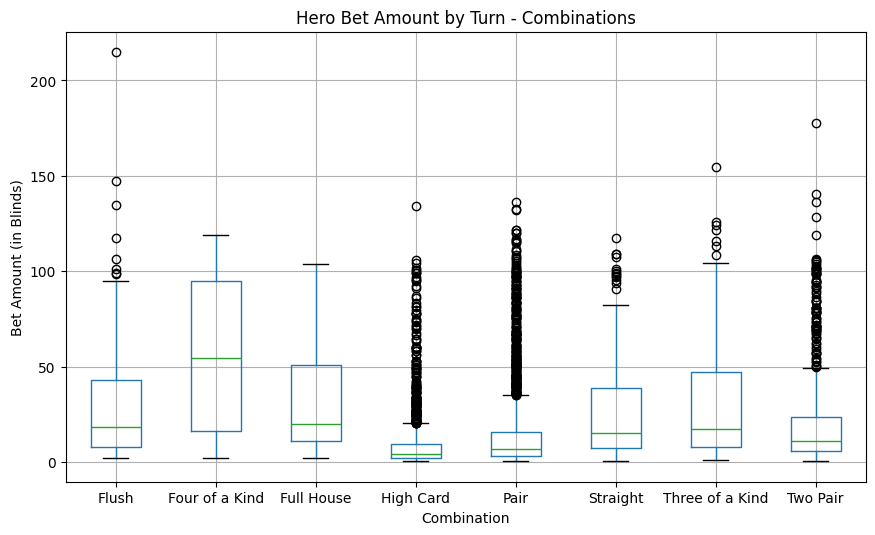

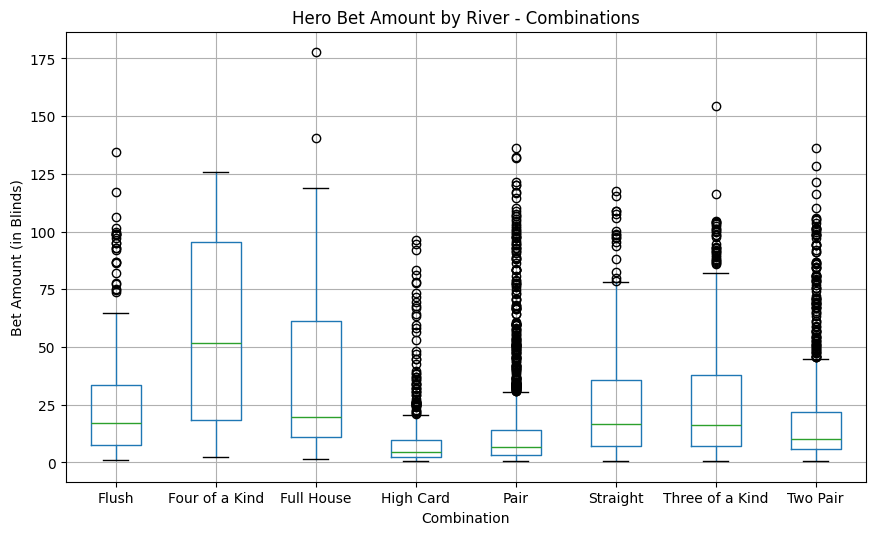

In [50]:
#Chart data hero
flop.boxplot(column='player0_bet', by='flop_hand', figsize=(10, 6), grid=True)
plt.title('Hero Bet Amount by Flop - Combinations')
plt.suptitle('')
plt.xlabel('Combination')
plt.ylabel('Bet Amount (in Blinds)')
plt.savefig("flop_combination_bet.png")
plt.show()
#Chart data hero
flop.boxplot(column='player0_bet', by='turn_hand', figsize=(10, 6), grid=True)
plt.title('Hero Bet Amount by Turn - Combinations')
plt.suptitle('')
plt.xlabel('Combination')
plt.ylabel('Bet Amount (in Blinds)')
plt.savefig("turn_combination_bet.png")
plt.show()
#Chart data hero
flop.boxplot(column='player0_bet', by='river_hand', figsize=(10, 6), grid=True)
plt.title('Hero Bet Amount by River - Combinations')
plt.suptitle('')
plt.xlabel('Combination')
plt.ylabel('Bet Amount (in Blinds)')
plt.savefig("river_combination_bet.png")
plt.show()